#### **A Manually Trained CNN for Bird Image Classification**

By Helen

Data source:

*   https://www.kaggle.com/datasets/gpiosenka/100-bird-species
* The dataset is reformated using codes from `load_split_data.ipynb`

Part of the codes in this notebook is based on the following Kaggle Notebooks:


*   https://www.kaggle.com/code/immortal36/bird-classification-cnn-not-pretrained-83-8
*   https://www.kaggle.com/code/akimball002/100-birds-cnn

Model description:

* With adjustment of train/valid/test split and hyperparamter optimization by Bayesian Optimization

**Note:**
* This notebook is designed to run in Kaggle Notebook. Please make changes accordingly if you are running this notebook in other environments.

Plan:
- data augmentation
- adjust train/valid/test split
- hyperparameter search
- examine misclassified birds - which bird species? male vs female?
- predict new bird images
- (thoughts only) AE to reconstruct bird images/ VAE to generate new bird images

In [1]:
#Used to make data more uniform across screen.
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.4.6
    Uninstalling keras-tuner-1.4.6:
      Successfully uninstalled keras-tuner-1.4.6


In [3]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from IPython.display import Image, display
import random
import math

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

#For modeling and model viewing.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend, models
from tensorflow import keras
import keras_tuner as kt

#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

2024-06-08 08:04:49.070475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 08:04:49.070576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 08:04:49.195201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if using gpu

In [4]:
print("Number of GPU(s) Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU(s) Available:  1


#### Configuring Kaggle data source

In [5]:
#shutil.rmtree("/kaggle/working/100-bird-species")

In [6]:
# Source directory
src_dir = "/kaggle/input/100-bird-species"

# Destination directory
dst_dir = "/kaggle/working/100-bird-species"

# Copy the directory
shutil.copytree(src_dir, dst_dir)

'/kaggle/working/100-bird-species'

In [7]:
#This will setup my directories for all of the data files in the 100-bird-species dataset.
BASE_DIR = '/kaggle/working/100-bird-species'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['valid', 'train', 'test', 'birds.csv', 'EfficientNetB0-525-(224 X 224)- 98.97.h5']


In [8]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

525 CATEGORIES are  ['WILSONS BIRD OF PARADISE', 'COLLARED ARACARI', 'BREWERS BLACKBIRD', 'CHUKAR PARTRIDGE', 'GOLD WING WARBLER', 'FAIRY PENGUIN', 'ANNAS HUMMINGBIRD', 'NORTHERN FLICKER', 'FLAME BOWERBIRD', 'TAIWAN MAGPIE', 'CUBAN TROGON', 'AFRICAN CROWNED CRANE', 'HORNED LARK', 'WRENTIT', 'CALIFORNIA GULL', 'BLOOD PHEASANT', 'PAINTED BUNTING', 'TURQUOISE MOTMOT', 'CRESTED SERPENT EAGLE', 'RED WISKERED BULBUL', 'RED CROSSBILL', 'NORTHERN SHOVELER', 'WOODLAND KINGFISHER', 'AUSTRAL CANASTERO', 'EMU', 'BLUE GROUSE', 'RED TAILED THRUSH', 'ZEBRA DOVE', 'YELLOW CACIQUE', 'AUSTRALASIAN FIGBIRD', 'EASTERN YELLOW ROBIN', 'TAILORBIRD', 'BANDED PITA', 'BUSH TURKEY', 'MERLIN', 'SNOW PARTRIDGE', 'CAPE MAY WARBLER', 'EASTERN MEADOWLARK', 'AZURE TANAGER', 'RUDY KINGFISHER', 'GROVED BILLED ANI', 'AZARAS SPINETAIL', 'CLARKS NUTCRACKER', 'GRAY CATBIRD', 'CROW', 'GUINEA TURACO', 'BULWERS PHEASANT', 'CAPPED HERON', 'COMMON IORA', 'INLAND DOTTEREL', 'ANTILLEAN EUPHONIA', 'NOISY FRIARBIRD', 'BALI STARLING'

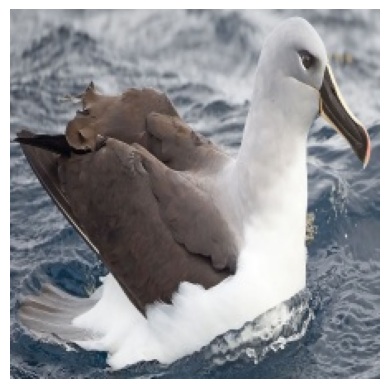

Figures are  (224, 224, 3)


In [9]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("/kaggle/working/100-bird-species/train/ALBATROSS/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

#### Data cleaning - there's an extra space for one of the birds in the train and test dir

In [10]:
def check_directories(path):
    subdirs = os.listdir(path)
    print(f'Total directories in {path}: {len(subdirs)}')
    return set(os.listdir(path))

# Retrieve the list of species in each directory
train_species = check_directories(TRAIN_DIR)
test_species = check_directories(TEST_DIR)
valid_species = check_directories(VALIDATION_DIR)

# Find the union of all species (all species that appear in any directory)
all_species = train_species.union(test_species).union(valid_species)

# Find what is missing from each set
missing_from_train = all_species - train_species
missing_from_test = all_species - test_species
missing_from_valid = all_species - valid_species

print("Species missing from train:", missing_from_train)
print("Species missing from test:", missing_from_test)
print("Species missing from valid:", missing_from_valid)

Total directories in /kaggle/working/100-bird-species/train: 525
Total directories in /kaggle/working/100-bird-species/test: 525
Total directories in /kaggle/working/100-bird-species/valid: 525
Species missing from train: {'PARAKETT AUKLET'}
Species missing from test: {'PARAKETT AUKLET'}
Species missing from valid: {'PARAKETT  AUKLET'}


In [11]:
# Define the incorrect and correct paths for train and test
incorrect_path_train = os.path.join(TRAIN_DIR, 'PARAKETT  AUKLET')
correct_path_train = os.path.join(TRAIN_DIR, 'PARAKETT AUKLET')

incorrect_path_test = os.path.join(TEST_DIR, 'PARAKETT  AUKLET')
correct_path_test = os.path.join(TEST_DIR, 'PARAKETT AUKLET')

# Rename the directories in train and test
try:
    os.rename(incorrect_path_train, correct_path_train)
    print(f"Renamed in train from '{incorrect_path_train}' to '{correct_path_train}'")
except FileNotFoundError as e:
    print(f"Error in train rename: {e}")

try:
    os.rename(incorrect_path_test, correct_path_test)
    print(f"Renamed in test from '{incorrect_path_test}' to '{correct_path_test}'")
except FileNotFoundError as e:
    print(f"Error in test rename: {e}")

Renamed in train from '/kaggle/working/100-bird-species/train/PARAKETT  AUKLET' to '/kaggle/working/100-bird-species/train/PARAKETT AUKLET'
Renamed in test from '/kaggle/working/100-bird-species/test/PARAKETT  AUKLET' to '/kaggle/working/100-bird-species/test/PARAKETT AUKLET'


In [12]:
# Retrieve the list of species in each directory
train_species = check_directories(TRAIN_DIR)
test_species = check_directories(TEST_DIR)
valid_species = check_directories(VALIDATION_DIR)

# Find the union of all species (all species that appear in any directory)
all_species = train_species.union(test_species).union(valid_species)

# Find what is missing from each set
missing_from_train = all_species - train_species
missing_from_test = all_species - test_species
missing_from_valid = all_species - valid_species

print("Species missing from train:", missing_from_train)
print("Species missing from test:", missing_from_test)
print("Species missing from valid:", missing_from_valid)

Total directories in /kaggle/working/100-bird-species/train: 525
Total directories in /kaggle/working/100-bird-species/test: 525
Total directories in /kaggle/working/100-bird-species/valid: 525
Species missing from train: set()
Species missing from test: set()
Species missing from valid: set()


#### Move around images so its roughly 80/10/10 split:
Can manually specify a different split by choosing num_test_files and num_valid_files variables

By moving 25 files into test/valid

In [13]:
# counts files
def count_images(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_images(TRAIN_DIR)
valid_count = count_images(VALIDATION_DIR)
test_count = count_images(TEST_DIR)
train_split = train_count / (train_count+test_count+valid_count)
valid_split = valid_count / (train_count+test_count+valid_count)
test_split = test_count / (train_count+test_count+valid_count)


print(f"Number of images in Train: {train_count} with split: {train_split}")
print(f"Number of images in Valid: {valid_count} with split: {valid_split}")
print(f"Number of images in Test: {test_count} with split: {test_split}")

Number of images in Train: 84635 with split: 0.9415920342660066
Number of images in Valid: 2625 with split: 0.029203982866996717
Number of images in Test: 2625 with split: 0.029203982866996717


In [14]:
def adjust_dataset_split(train_dir, test_dir, valid_dir, num_test_files, num_valid_files):
    """
    Adjusts the dataset split by moving specified numbers of files from each species' training directory
    to its corresponding test and validation directories, ensuring files are moved in numerical order.
    Skips files named '1.jpg' to '5.jpg' to avoid conflicts.
    """
    skipped_files = {'1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg'}  # Files to skip

    for species in os.listdir(train_dir):
        species_train_dir = os.path.join(train_dir, species)
        species_test_dir = os.path.join(test_dir, species)
        species_valid_dir = os.path.join(valid_dir, species)

        os.makedirs(species_test_dir, exist_ok=True)
        os.makedirs(species_valid_dir, exist_ok=True)

        # sort by numeric order
        files = os.listdir(species_train_dir)
        files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))  # Sort by numeric value extracted from filenames

        # ensure enough files are moved
        available_files = [f for f in files if f not in skipped_files]
        test_files_to_move = available_files[:num_test_files]
        for file in test_files_to_move:
            shutil.move(os.path.join(species_train_dir, file), os.path.join(species_test_dir, file))
           # print(f"Moved {file} to {species_test_dir}")

        # remaining files
        remaining_files = [f for f in os.listdir(species_train_dir) if f not in skipped_files]
        remaining_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        valid_files_to_move = remaining_files[:num_valid_files]
        for file in valid_files_to_move:
            shutil.move(os.path.join(species_train_dir, file), os.path.join(species_valid_dir, file))
            print(f"Moved {file} to {species_valid_dir}")

#  number of files to move to respective directories
num_test_files = 10
num_valid_files = 10

adjust_dataset_split(TRAIN_DIR, TEST_DIR, VALIDATION_DIR, num_test_files, num_valid_files)
print("Files have been moved to achieve the specified dataset split.")

Moved 011.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 012.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 013.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 014.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 015.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 016.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 017.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 018.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 019.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 020.jpg to /kaggle/working/100-bird-species/valid/WILSONS BIRD OF PARADISE
Moved 011.jpg to /kaggle/working/100-bird-species/valid/COLLARED ARACARI
Moved 012.jpg to /kaggle/working/100-bird-species/valid/COLLARED ARACARI
Moved 013.jpg to /kaggle/working/100-bird-sp

In [15]:
train_count = count_images(TRAIN_DIR)
valid_count = count_images(VALIDATION_DIR)
test_count = count_images(TEST_DIR)
train_split = train_count / (train_count+test_count+valid_count)
valid_split = valid_count / (train_count+test_count+valid_count)
test_split = test_count / (train_count+test_count+valid_count)


print(f"Number of images in Train: {train_count} with split: {train_split}")
print(f"Number of images in Valid: {valid_count} with split: {valid_split}")
print(f"Number of images in Test: {test_count} with split: {test_split}")

Number of images in Train: 74135 with split: 0.8247761027980197
Number of images in Valid: 7875 with split: 0.08761194860099016
Number of images in Test: 7875 with split: 0.08761194860099016


I'll create instances of ImageDataGenerators. One for all of the data being processed and more if I decide to augment my training data.

In [16]:
#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, ) #Normalize pixel values to [0, 1] range using a floating-point scaling factor


The directories are not direct links to the data so I used the IMAGEDATAGENERATOR in Keras to consolidate the images for each train/test/validation set. I left the defaults as follows: batch_size = 32, class_mode = 'categorical', shuffle = TRUE(in flow).

In [17]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 74135 images belonging to 525 classes.
data groups: 2317
Found 7875 images belonging to 525 classes.
data groups: 247
validation image qty: 7875
Found 7875 images belonging to 525 classes.
data groups: 247


So to make certain my new datasets still had images and label seperation, I printed a few more images from the test set.

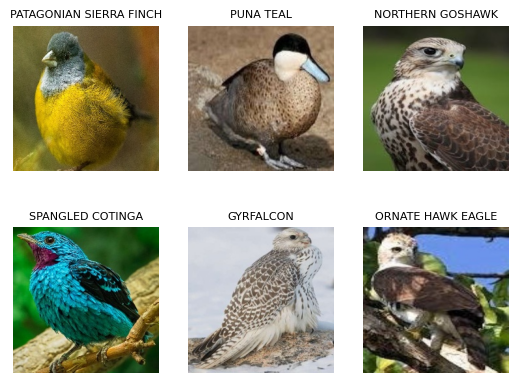

In [18]:
#create seperate labels for images
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames)) #prints out random images each time
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TRAIN_DIR, train_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

#### Model training

I will apply the Hyperband Tuner in the Keras Tuner to optimize the hyperparameters.

First, we build a model and define the hyperparameter space.

In [19]:
def build_model(hp):
    model = Sequential()

    # Base Model
    model.add(Conv2D(
        hp.Int('conv1_filters', min_value=32, max_value=64, step=8),
        (hp.Int('conv1_kernel_size', min_value=2, max_value=4, step=1)),
        input_shape=(224, 224, 3),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(
        hp.Int('conv2_filters', min_value=48, max_value=80, step=16),
        (hp.Int('conv2_kernel_size', min_value=3, max_value=5, step=1)),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(
        hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        (hp.Int('conv3_kernel_size', min_value=3, max_value=5, step=1)),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(
        hp.Int('conv4_filters', min_value=128, max_value=256, step=64),
        (hp.Int('conv4_kernel_size', min_value=3, max_value=5, step=1)),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(
        hp.Int('conv5_filters', min_value=256, max_value=512, step=128),
        (hp.Int('conv5_kernel_size', min_value=3, max_value=5, step=1)),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    # Top Model
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)))

    model.add(Dense(
        hp.Int('dense_units', min_value=256, max_value=512, step=128),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.1, default=0.2)))

    model.add(Dense(Category_count, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

We then create a Keras Tuner instance to search over the hyperparameter space.

In [20]:
# Create the results directory if it doesn't exist
os.makedirs('/kaggle/working/results', exist_ok=True)

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=70,
    num_initial_points=35,
    executions_per_trial=1,
    overwrite=True,
    directory='/kaggle/working/results',
    project_name='bird_cnn_bayesian'
)
    
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=0
)

"""
checkpoint_path = "/kaggle/working/checkpoint/checkpoint.model.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=0
)



# To visualize the hyperparameter tuning process
tensorboard_callback = keras.callbacks.TensorBoard("/kaggle/working/tb_logs")
"""

tuner.search(
    train_data,
    validation_data=validation_data,
    epochs=5,
    callbacks=[early_stopping]
)

Trial 26 Complete [00h 17m 47s]
val_accuracy: 0.690412700176239

Best val_accuracy So Far: 0.7518730163574219
Total elapsed time: 04h 55m 44s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
64                |64                |conv1_filters
2                 |4                 |conv1_kernel_size
64                |48                |conv2_filters
5                 |5                 |conv2_kernel_size
64                |128               |conv3_filters
5                 |4                 |conv3_kernel_size
256               |256               |conv4_filters
4                 |5                 |conv4_kernel_size
512               |256               |conv5_filters
3                 |5                 |conv5_kernel_size
0.1               |0.5               |dropout_rate
384               |384               |dense_units
0.4               |0.3               |dropout_rate2
0.00073257        |0.00035534        |learning_rate

Epoch 1/5
2317/2317 ━━━━━━━━━━━

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir /kaggle/working/tb_logs

In [ ]:
best_model = build_model(tuner.get_best_hyperparameters(1)[0])
history = best_model.fit(train_data, epochs=20, validation_data=validation_data, verbose=1)

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.savefig('/kaggle/working/Model_accuracy_bayesian.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.savefig('/kaggle/working/Model_loss_bayesian.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white')
plt.show()

# Evaluate the best model against test data.
scores = best_model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/kaggle/working/CNN_not_pretrained_bayesian.keras')

In [ ]:
# Evaluate the best model against test data.
scores = best_model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

#### Sanity check: reload saved model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
reload_model = load_model('/kaggle/working/CNN_not_pretrained_bayesian.keras')

In [ ]:
reload_scores = reload_model.evaluate(test_data, verbose=1)
print('Test loss:', reload_scores[0])
print('Test accuracy:', reload_scores[1])